<a href="https://colab.research.google.com/github/LeVuPhuoc/KT_21-5/blob/main/2020_12_23_Classifier2ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Turn a CNN into an object classifier
> Turn a CNN into an object classifier. This follows a tutorial  by.

- toc: true 
- badges: true
- comments: true
- categories: [Keras, CNN]
- image: images/chart-preview.png

# 1. Classification vs Object Detection

Classification:
   - One image in
   - One class label out
   
Object detection:
   - Input one image
   - Obtain multiple bounding boxes and class labels as output   

In [1]:
#collapse-hide
import imutils
import numpy as np
import cv2
import matplotlib.pyplot as plt
import argparse
import tensorflow as tf
import imutils
from imutils.object_detection import non_max_suppression
import time
print(tf.__version__, cv2.__version__)

2.8.2 4.1.2


## 2. Object detection algorithm pattern

   1. Input: an image that we wish to apply object detection to
   
   2. Output: has three values:
   
        2a. A list of bounding boxes, or the (x, y)-coordinates for each object in  image
        
        2b. The class label associated with each of the bounding boxes
        
        2c. The probability/confidence score associated with each bounding box and class label

## 2.  Turn any classifier into an object detector

  - Before ANN-CNN  era state of the for object detection was HOG(Histogarm of Oriented Gardients) + SVM
  - This tutorial combines several approaches:
  
   1. Image pyramids: Localize objects at different scales/sizes (is a multi-scale representation of an image)
   2. Sliding windows: Detect exactly where in the image a given object is.
   3. Non-maxima suppression: Collapse weak, overlapping bounding box

In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/MyDrive/Colab Notebooks/AI')
# !unzip natural_disasters.zip
!ls

Mounted at /content/gdrive
2020-12-23-Classifier2ObjectDetection.ipynb  model_acc_0.48997965455055237.h5
Classification_15_flowers.ipynb		     model_acc_0.5553296804428101.h5
images					     model_acc_0.5602672100067139.h5
model_acc_0.05808887630701065.h5	     model_acc_0.561428964138031.h5
model_acc_0.1536450833082199.h5		     model_acc_0.5884402990341187.h5
model_acc_0.23758350312709808.h5	     model_acc_0.6049956679344177.h5
model_acc_0.25442928075790405.h5	     model_acc_0.6659889817237854.h5
model_acc_0.32820215821266174.h5	     model_acc_0.7060703039169312.h5
model_acc_0.34766191244125366.h5	     model_acc_0.7066511511802673.h5
model_acc_0.3581179082393646.h5		     model_acc_0.711007833480835.h5
model_acc_0.379901260137558.h5		     real-time.ipynb
model_acc_0.3825152516365051.h5		     train_flowers
model_acc_0.44408944249153137.h5	     train_flowers.zip
model_acc_0.45425501465797424.h5	     valid_flowers
model_acc_0.47516700625419617.h5	     valid_flowers.zip


In [3]:
import imutils
import numpy as np
import cv2
import matplotlib.pyplot as plt
import argparse
import tensorflow as tf
import imutils
from imutils.object_detection import non_max_suppression
import time

In [334]:
#collapse-hide 
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", default = "/content/gdrive/MyDrive/Colab Notebooks/AI/valid_flowers/daisy/144076848_57e1d662e3_m.jpg", #required=False,
    help="path to the input image")
ap.add_argument("-s", "--size", type=str, default="(200, 150)",
    help="ROI size (in pixels)")
ap.add_argument("-c", "--min-conf", type=float, default=0.7,
    help="minimum probability to filter weak detections")
ap.add_argument("-v", "--visualize", type=int, default=1,
    help="whether or not to show extra visualizations for debugging")
args = vars(ap.parse_args([]))

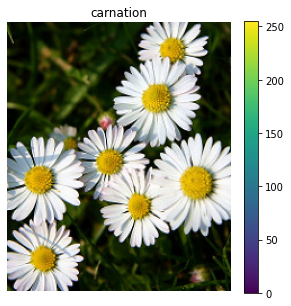

In [335]:
image = cv2.imread(args["image"])

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_title("carnation")
plt.imshow(image)
plt.axis("off")
plt.colorbar()

## 3. Construct a sliding window generator

The sliding function is constructed as a generator.

Sliding window and ROIs for an image with three hierachical pyramids.

![](https://github.com/simsisim/sims-pyimage/blob/master/_notebooks/images/keras_detection/sliding_window_sw.gif?raw=1)

In [336]:
def sliding_window(image, step, ws):
    for y in range(0, image.shape[0]-ws[1], step): 
        for x in range(0, image.shape[1] - ws[0], step):
            yield (x, y, image[y:y + ws[1], x:x + ws[0]]) 

##  4. Construct a pyramid generator

The image_pyramid function is constructed as a generator.

At the bottom of the pyramid, we have the original image at its original size (in terms of width and height). At each subsequent layer, the image is resized (subsampled)  by a scaling factor and optionally smoothed (usually via Gaussian blurring). The image is progressively subsampled(adding pyramids) until some stopping criterion is met, which is normally when a minimum size has been reached(smaller than the sliding window size).

Image resizing take place in two steps:

  - resize by scale - to construct the next layer in the pyramid (size of image is drastically reduced)
 
  - resize to keep image aspect-ratio (of the image in that pyramid layer, size the image will be slightly fit)

In [337]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image, this is the base of the image pyramid
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        #scale controls how much the image is resized at each layer
        w = int(image.shape[1] / scale)
        # resize the image and take care of image aspect-ratio
        image = imutils.resize(image, width=w) 
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

In [338]:
# initialize variables used for the object detection procedure
WIDTH = 600 # 
PYR_SCALE = 1.5
WIN_STEP = 16*3 # running on laptop so I generated a small pyramid
ROI_SIZE = eval(args["size"])
INPUT_SIZE = (224, 224) # input of resnet model.summary()

In [339]:
# download pretrained model
print("[INFO] loading network...")
# model = tf.keras.applications.resnet.ResNet50(weights = "imagenet", include_top = "True")
model = tf.keras.models.load_model('./model_acc_0.711007833480835.h5')
# model.summary()
print("...Done")

[INFO] loading network...
...Done


In [340]:
# resize  image- note that it doesn not fit the input to ResNet50
orig = image
orig = imutils.resize(orig, width = WIDTH)
(H, W) = orig.shape[:2] # 800, 600


## 6. Classification of ROIs 

For each level in the pyramid run the sliding window. For each stop of the sliding window extract the window part of that image (ROI). Take the ROI and pass it trough the pre-trainied classifier. Look at the classification results, if fpr that ROI a classification result is greater than a minimum threshold, then record the class label and the position of the ROI/window in the original file name.

In [341]:
# initialize the image pyramid
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
# initialize two lists, one to hold the ROIs generated from the image pyramid 
#and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []
# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()
counter = 0
tot_images = 0
for p, image in enumerate(pyramid):
    # determine the scale factor between the *original* image
    # dimensions and the *current* layer of the pyramid
    scale = W / float(image.shape[1])
    # for each layer of the image pyramid, loop over the sliding
    # window locations
    sw = 0
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        sw = sw + 1
        # scale the (x, y)-coordinates of the ROI with respect to the
        # *original* image dimensions
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)
        # take the ROI and pre-process it so we can later classify
        # the region using Keras/TensorFlow
        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = tf.keras.preprocessing.image.img_to_array(roi)
        roi = tf.keras.applications.resnet.preprocess_input(roi)
        #print(roiOrig.shape, roi.shape)
        # update our list of ROIs and associated coordinates
        rois.append(roi)
        locs.append((x, y, x + w, y + h))
        # check to see if we are visualizing each of the sliding
        # windows in the image pyramid
        if args["visualize"] > 0:
            # clone the original image and then draw a bounding box
            # surrounding the current region
            clone = orig.copy()
            cv2.rectangle(clone, (x, y), (x + w, y + h),(0, 255, 0), 5)
            tot_images = tot_images +1
print(roiOrig.shape, roi.shape)
# show how long it took to loop over the image pyramid layers and
# sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(end - start))
print("Total images {:.2f}".format(tot_images))

(150, 200, 3) (224, 224, 3)
[INFO] looping over pyramid/windows took 0.18334 seconds
Total images 151.00


In [342]:
# convert the ROIs to a NumPy array
rois = np.array(rois, dtype="float32")
# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
my_preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(end - start))

[INFO] classifying ROIs...
[INFO] classifying ROIs took 1.44157 seconds


In [343]:
my_preds[0]
np.argmax(my_preds[1])
# len(my_preds)
labels_name = ['astilbe', 'bellflower', 'califonia_poppy', 'carnation', 'common_daisy', 
               'coreopsis', 'daffodil', 'daisy', 'dandelion', 'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily']
print(len(labels_name))
preds = []
for i in range(len(my_preds)):
  label = labels_name[np.argmax(my_preds[i])]
  prob = max(my_preds[i])
  pred = (label, prob)
  preds.append(pred)
  # # preds = 
  # print('---')
  # print(my_preds[i])
  # print(prob)

15


In [344]:
for (i, p) in enumerate(preds):
  (label, prob) = p
print(label, prob)

common_daisy 1.0


In [345]:
# preds = tf.keras.applications.imagenet_utils.decode_predictions(my_preds, top=1)
# preds[30:35]

In [346]:
# decode the predictions and initialize a dictionary which maps class
# labels (keys) to any ROIs associated with that label (values)
#preds = tf.keras.applications.imagenet_utils.decode_predictions(my_preds, top=1)
labels = {}
#probs = {}
# loop over the predictions
for (i, p) in enumerate(preds):
    # grab the prediction information for the current ROI
    (label, prob) = p#[0]
    # filter out weak detections by ensuring the predicted probability
    # is greater than the minimum probability
    if prob >= args["min_conf"]:
        # grab the bounding box associated with the prediction and
        # convert the coordinates
        box = locs[i]

        # grab the list of predictions for the label and add the
        # bounding box and probability to the list
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L

In [347]:
# labels

[INFO] showing results for 'sunflower'
len:  10
[INFO] showing results for 'common_daisy'
len:  8
[INFO] showing results for 'dandelion'
len:  1
[INFO] showing results for 'tulip'
len:  6
[INFO] showing results for 'daisy'
len:  7
[INFO] showing results for 'carnation'
len:  1
[INFO] showing results for 'califonia_poppy'
len:  1
[INFO] showing results for 'daffodil'
len:  1


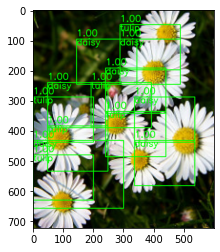

In [349]:
# loop over the labels for each of detected objects in the image
allclone = orig.copy()
for label in labels.keys():
    # clone the original image so that we can draw on it
    print("[INFO] showing results for '{}'".format(label))
    clone = orig.copy()

    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)

    # show the results *before* applying non-maxima suppression, then
    # clone the image again so we can display the results *after*
    # applying non-maxima suppression
    #plt.imshow(clone)
    #cv2.imshow("Before", clone)
    clone = orig.copy()

    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)
    print("len: ", len(boxes))
    if len(boxes) >= 5 and len(boxes)<8:
    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
      for (startX, startY, endX, endY) in boxes:
          # draw the bounding box and label on the image
          cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
          cv2.rectangle(allclone, (startX, startY), (endX, endY),(0, 255, 0), 2)
          y = startY - 10 if startY - 10 > 10 else startY + 10
          
          # print('clone: ', clone)
          cv2.putText(clone, str(label), (startX, y+30),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
          cv2.putText(clone, "{:.2f}".format(prob), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
          cv2.putText(allclone, str(label), (startX, y+30),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
          cv2.putText(allclone, "{:.2f}".format(prob), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)        
    # show the output after apply non-maxima suppression
      plt.imshow(clone)
      plt.imsave("images/_res03_" + str(label) + ".jpg", clone) 
plt.imshow(allclone)
plt.imsave("images/_allclone03.jpg", allclone)     


## 7. The general flow of the algorithm

  1. Input an image
  2. Construct an image pyramid
  3. For each scale of the image pyramid, run a sliding window
  
        3a. For each stop of the sliding window, extract the ROIs
        
        3b. Take the ROIs and pass it through our CNN originally trained for image classification
        
        3c. Examine the probability of the top class label of the CNN, and if meets a minimum confidence, record (1) the class label and (2) the location of the sliding window
        
  4. Apply class-wise non-maxima suppression to the bounding boxes
  5. Return results to calling function

## References:
> https https://www.pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/

> https https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/

In [ ]:
import os

import glob

import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.layers import Conv2D, BatchNormalization, ReLU, Activation


In [ ]:
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
import cv2
import numpy as np


model = load_model('model_acc_0.7066511511802673.h5')
name_label = ['astilbe', 'bellflower', 'califonia_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'daisy', 'dandelion', 'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily']

video_capture = cv2.VideoCapture('Video về các loài hoa.webm')

while True:
    ret, frame = video_capture.read()
    if not ret:
        break
    frame = cv2.resize(frame, (224, 224))
    frame = np.expand_dims(frame, axis=0)
    frame = frame.astype(np.float32)
    frame = frame / 255.0
    
    pred = model.predict(frame)
    model.add(
    Conv2D(
        filters=30,
        kernel_size=7,
        strides=1,
        padding='same',
        kernel_initializer='he_uniform',
    )
)
    pred = np.argmax(pred, axis=1)
    pred = name_label[pred[0]]
    print(pred)
    cv2.imshow('frame', frame[0])
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

ValueError: ignored